In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import timeit
from skimage import feature
import glob
import os
import collections
import scipy.signal

In [2]:
def GLCMFeature(frame,kernelSize):
    kernel = np.ones((kernelSize,kernelSize),np.float32)/25

    x = feature.greycomatrix(cv2.filter2D(frame,-1,kernel).astype('uint8'),distances=[10],angles=[180],normed=True,symmetric=True)
    contrast = feature.greycoprops(x,prop='contrast')[0]
    dissimilarity = feature.greycoprops(x,prop='dissimilarity')[0]
    homogeneity = feature.greycoprops(x,prop='homogeneity')[0]
    asm = feature.greycoprops(x,prop='ASM')[0]
    energy = feature.greycoprops(x,prop='energy')[0]
    
    return [contrast,dissimilarity,homogeneity,asm,energy]

def AGMM_Timer(queue):
    if len(queue) != 10:
        return False
    tmp = queue[0]
    for i in range(1,len(queue),1):
        if tmp != queue[i] -1:
            return False
    return True
    

def aperture_effect(queue):
    #print(queue)
    if len(queue) <10:
        return False
    else:
        last = queue[0]
        for i in range(1,len(queue),1):
            if last != queue[i] - 1:
                return False
            last = queue[i]
    return True

def defocus_delay(queue):
    if len(queue) <10:
        return False
    else:
        last = queue[0]
        for i in range(1,len(queue),1):
            if last != queue[i] - 1:
                #print("\t failed not connected")
                return False
            last = queue[i]
    #print("\t returning True")
    return True


def cross_image(im1, im2):
    im1 -= np.mean(im1).astype('uint8')
    im2 -= np.mean(im2).astype('uint8')

    return scipy.signal.fftconvolve(im1, im2[::-1,::-1], mode='same')

def k_largest_index_argpartition_v2(a, k):
    idx = np.argpartition(a.ravel(),a.size-k)[-k:]
    return np.column_stack(np.unravel_index(idx, a.shape))

In [3]:
class subWindow():
    def __init__(self,name,illuminationThreshold,textureThreshold,apertureLength,defocusThreshold,shiftTolerence,shiftRatio,learningRate):
        self.name = name
        self.trainingCache = collections.deque(maxlen = 2000)
        self.illuminationModel = None
        self.textureModel = None
        self.cache = collections.deque(maxlen = 40)
        self.shortTimeQue = collections.deque(maxlen = 20)
        self.occlusionDelayQue = collections.deque(maxlen = 20)
        self.defocusDelayQue = collections.deque(maxlen = 20)
        self.AGMM = cv2.createBackgroundSubtractorMOG2()
        self.shortAGMM = None
        self.learningRate = learningRate
        
        self.illuminationThreshold1 = illuminationThreshold
        self.illuminationThreshold2 = illuminationThreshold
        self.textureThreshold1 = textureThreshold
        self.textureThreshold2 = textureThreshold
        self.textureThreshold3 = textureThreshold
        self.textureThreshold4 = textureThreshold
        
        self.apertureLength = apertureLength
        self.defocusThreshold = defocusThreshold
        self.shiftTolerence = shiftTolerence
        self.shiftRatio = shiftRatio
        
        self.avgPixel = 0
        self.ORIGINALPOS = None
        self.shift = 0
    
    def learningParam(self):

        shift_value = []
        shift_amount = []
        illumination_value = []
        texture_value = []
        defocus_value = []
        
        ref_frame = np.zeros((self.trainingCache[0].shape[0],self.trainingCache[0].shape[1]))
        
        for i in range(len(self.trainingCache)):
            fg = self.AGMM.apply(self.trainingCache[i],learningRate=-1)
            ref_frame = ref_frame + self.trainingCache[i] - fg
        
        ref_frame = ref_frame / len(self.trainingCache)
        
        for i in range(0,len(self.trainingCache),1):
            fg = self.AGMM.apply(self.trainingCache[i],learningRate = 0)
            bg = self.trainingCache[i] - fg
            
            # illumination value
            mean, std = np.mean(bg), np.std(bg)
            illumination_value.append((mean,std))
            
            # GLCM value
            a,b,c,d,e = GLCMFeature(bg,kernelSize=20)
            texture_value.append((a,b,c,d,e))
            
            # AVG edge pixel number
            defocus_value.append(sum(sum((bg>0))))
            
            """# Shift value
            corr = cross_image(bg,ref_frame)
            
            topk = k_largest_index_argpartition_v2(corr_img,5)
            for k in topk:
                corx, cory = k
                shift_amount.append((corx,cory))
            shift_value.append(max(corr))
            """
        param = []
        """plt.plot(defocus_value)
        plt.title("AVG pixel")
        plt.show()"""
        defocusM = np.mean(defocus_value)
        defocusS = np.std(defocus_value)
        #print(max(abs(defocus_value-defocusM)),defocusM)
        param.extend([defocusM,max(abs(defocus_value-defocusM))/defocusS])
        
        illuminaMean_list = np.array([x[0] for x in illumination_value])
        """plt.plot(illuminaMean_list)
        plt.title("illumination Mean")
        plt.show()"""
        illumin1M = np.mean(illuminaMean_list)
        illumin1S = np.std(illuminaMean_list)
        #print(max(abs(illuminaMean_list-illumin1M)),illumin1M)
        param.append(max(abs(illuminaMean_list-illumin1M))/illumin1S)
        
        illuminaStd_list = np.array([x[1] for x in illumination_value])
        """plt.plot(illuminaStd_list)
        plt.title("illumination Std")
        plt.show()"""
        illumin2M = np.mean(illuminaMean_list)
        illumin2S = np.std(illuminaMean_list)
        #print(max(abs(illuminaMean_list-illumin2M)),illumin2M)
        param.append(max(abs(illuminaMean_list-illumin2M))/illumin2S)
        
        textureDev = []
        for i in range(len(texture_value[0])):
            #print("Texture Feature  ",i)
            tmp = np.array([x[i] for x in texture_value])
            """plt.plot(tmp)
            plt.show()"""
            tmpM = np.mean(tmp)
            tmpS = np.std(tmp)
            #print(max(abs(tmp-tmpM)),tmpM)
            textureDev.append(max(abs(tmp-tmpM))/tmpS)
        param.append(textureDev)
        
        self.settingParam(param)
         
    def settingParam(self,paramList):
        avgP,defocus, illu1, illu2, textureDev = paramList
        
        self.illuminationThreshold1 = illu1
        self.illuminationThreshold2 = illu2
        self.avgPixel = avgP
        self.defocusThreshold = defocus/2
        self.textureThreshold1 = textureDev[0]*2
        self.textureThreshold2 = textureDev[1]*2
        self.textureThreshold3 = textureDev[2]*2
        self.textureThreshold4 = textureDev[3]*2
        self.textureThreshold5 = textureDev[4]*2
        
        
        
    def AGMMLearn(self):
        for frame in self.cache:
            self.AGMM.apply(frame,learningRate = -1)
            
    def computeAvgPixel(self):
        edgepixel = []
        for frame in self.cache:
            edgepixel.append(sum(sum(frame)))
        self.avgPixel = np.mean(edgepixel)
        
    def construct_illumination_model(self,init):
        if init == 0:
            video = self.cache
        else:
            video = self.trainingCache
        meanLst = []
        stdLst = []
        for i in range(0,len(video),1):
            meanLst.append(np.mean(video[i]))
            stdLst.append(np.std(video[i]))
        meanMean = np.mean(np.array(meanLst))
        meanStd = np.std(np.array(meanLst))
        stdMean = np.mean(np.array(stdLst))
        stdStd = np.std(np.array(stdLst))
        return [meanMean,meanStd,stdMean,stdStd]
    
    def suddenIlluminationChangeDetection(self):
        frame = self.cache[-1]
        tmpfg = frame - self.AGMM.apply(self.cache[-2],learningRate = 0)
        meanMean,meanStd,stdMean,stdStd = self.illuminationModel
        tmpmean = np.mean(frame)
        tmpstd = np.std(frame)
        #print("In ill Dect",abs(tmpmean-meanMean),meanStd,abs(tmpstd-stdMean),stdStd)
        if tmpmean > meanMean + self.illuminationThreshold1 * meanStd  or tmpmean < meanMean - self.illuminationThreshold1 * meanStd:
            if tmpstd > stdMean + self.illuminationThreshold2 * stdStd or tmpstd < stdMean - self.illuminationThreshold2 * stdStd:
                return True,(abs(tmpmean-meanMean)/meanStd,abs(tmpstd-stdMean)/stdStd)
        return False,(abs(tmpmean-meanMean)/meanStd,abs(tmpstd-stdMean)/stdStd)
    
    def shiftDetection(self,illumi_flag,frameID):
        frame = self.cache[-1]
        if illumi_flag == 0:
            tmpbg = self.cache[-1] - self.AGMM.apply(self.cache[-1],learningRate = 0)
            corr_img = cross_image(tmpbg,self.ORIGINALPOS)
            midx, midy = int(corr_img.shape[0]/2),int(corr_img.shape[1]/2)
            norVale = corr_img[midx,midy]
            corr_img[midx-self.shiftTolerence:midx+self.shiftTolerence,midy-self.shiftTolerence:midy+self.shiftTolerence] = 0
            topk = k_largest_index_argpartition_v2(corr_img,5)
            for k in topk:
                corx, cory = k
                
                #print(frameID,corr_img[corx,cory]/norVale)
                if corr_img[corx,cory]/norVale > self.shiftRatio:
                    print(" ===== Shift =====",self.name)
                    self.shift = 1
                    break
        else:
            return (False, 0)
            
        if self.shift == 1:
            return (True,corr_img[corx,cory]/norVale)
        return (False, corr_img[corx,cory]/norVale)
    
    def construst_GLCM_model(self,init):
        constrastLst =[]
        dissimilarityLst = []
        homogeneityLst = []
        asmLst = []
        energyLst = []
        if init == 0:
            video = self.trainingCache
        else:
            video = self.cache
        for i in range(0,len(video),1):
            a,b,c,d,e = GLCMFeature(video[i]-self.AGMM.apply(video[i],learningRate=0),20)
            constrastLst.append(a)
            dissimilarityLst.append(b)
            homogeneityLst.append(c)
            asmLst.append(d)
            energyLst.append(e)
        #print("Constructing Texture",np.mean(constrastLst),np.std(constrastLst),np.mean(dissimilarityLst),np.std(dissimilarityLst),np.mean(homogeneityLst),np.std(homogeneityLst),np.mean(asmLst),np.std(asmLst),np.mean(energyLst),np.std(energyLst))
        return [np.mean(constrastLst),np.std(constrastLst),np.mean(dissimilarityLst),np.std(dissimilarityLst),np.mean(homogeneityLst),np.std(homogeneityLst),np.mean(asmLst),np.std(asmLst),np.mean(energyLst),np.std(energyLst)]

    def suddenTextureChangeDetection(self,frameID):
        frame = self.cache[-1]
        conM,conS,disM,disS,homM,homS,asmM,asmS,ergM,ergS = self.textureModel
        tmpcon,tmpdis,tmphom,tmpasm,tmperg = GLCMFeature(frame,20)
        
        
        if (tmpcon > conM + self.textureThreshold1 * conS or tmpcon < conM - self.textureThreshold1*conS) and (tmpdis > disM + self.textureThreshold2*disS or tmpdis < disM - self.textureThreshold2*disS) and (tmphom > homM + self.textureThreshold3*homS or tmphom < homM - self.textureThreshold3*homS) and (tmpasm > asmM + self.textureThreshold4*asmS or tmpasm < asmM - self.textureThreshold4*asmS) and (tmperg > ergM + self.textureThreshold5*ergS or tmperg < ergM - self.textureThreshold5*ergS):
            self.occlusionDelayQue.append(frameID)
            print(" ===== texture change =====",frameID,self.name)
            return True,((abs(tmpcon-conM)/conS)[0],(abs(tmpdis-disM)/disS)[0],(abs(tmphom-homM)/homS)[0],(abs(tmpasm-asmM)/asmS)[0],(abs(tmperg-ergM)/ergS)[0])
        
        return False,((abs(tmpcon-conM)/conS)[0],(abs(tmpdis-disM)/disS)[0],(abs(tmphom-homM)/homS)[0],(abs(tmpasm-asmM)/asmS)[0],(abs(tmperg-ergM)/ergS)[0])
    
    def textureModelUpdate(self, illumi_flag,frameID):
        frame = self.cache[-1]
        if illumi_flag == 1:
            if len(self.shortTimeQue) == 0:
                self.shortAGMM = cv2.createBackgroundSubtractorMOG2()
                self.shortAGMM.apply(frame - self.AGMM.apply(frame,learningRate=0),learningRate = self.learningRate)
                self.shortTimeQue.append(frameID)
            else:
                self.shortAGMM.apply(frame, learningRate = self.learningRate)
                self.shortTimeQue.append(frameID)
                if AGMM_Timer(self.shortTimeQue):
                    print(" ===== Time ", frameID, " Short AGMM Replace Long AGMM ===== ",self.name)
                    self.AGMM = self.shortAGMM
                    self.shortTimeQue.clear()
                    self.shortAGMM = None
                    self.illuminationModel = construct_illumination_model(self.cache)
                    return True
        else:
            self.AGMM.apply(frame,learningRate = self.learningRate)
            self.illuminationModel = self.construct_illumination_model(init = 1)
            self.computeAvgPixel()
        
        return False
        
    def defocusDetection(self,illumi_flag, frameID):
        frame = self.cache[-1]
        #print("\tCHECKING DECOFUS \t ",sum(sum(frame - self.AGMM.apply(frame,learningRate = 0))),self.avgPixel,self.def)
        if sum(sum(frame - self.AGMM.apply(frame,learningRate = 0))) / self.avgPixel < self.defocusThreshold:
            self.defocusDelayQue.append(frameID)
            if (defocus_delay(self.defocusDelayQue) and illumi_flag == 1) or illumi_flag == 0:
                print(" ===== At ", frameID," Defocus Detected ===== ",self.name)
                return True,sum(sum(frame - self.AGMM.apply(frame,learningRate = 0))) / self.avgPixel
        return False, sum(sum(frame - self.AGMM.apply(frame,learningRate = 0))) / self.avgPixel
            

In [4]:
video = []
file = sorted(glob.glob("C:/Users/Jimmy/Desktop/Everguard/Image Sabotage/jpgFile/Factory/1/*.jpg"), key=os.path.getmtime)
c = 0
for frame in file:
    
    if c >= 4200 :
        break
    f = cv2.imread(frame)
    video.append(f)
    c = c + 1
    #video.append(f[:int(f.shape[0]/2),:int(f.shape[1]/2)])
print(len(video))

4200


2000


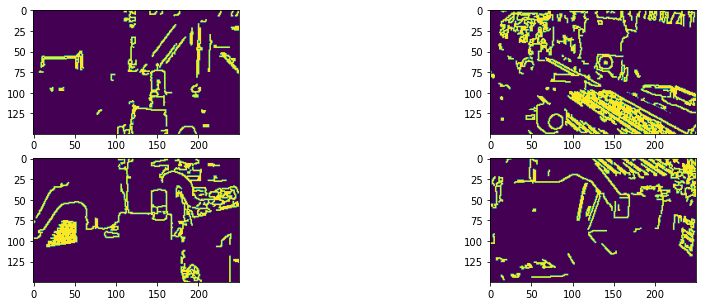

 ===== At  2001  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2001  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2001  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2001  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2002  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2002  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2002  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2002  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2003  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2003  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2003  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2003  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2004  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2004  Defocus 

 ===== At  2029  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2029  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2029  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2029  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2030  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2030  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2030  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2030  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2031  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2031  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2031  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2031  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2032  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2032  Defocus 

 ===== At  2057  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2057  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2057  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2057  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2058  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2058  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2058  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2058  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2059  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2059  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2059  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2059  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2060  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2060  Defocus 

 ===== At  2085  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2085  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2085  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2085  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2086  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2086  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2086  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2086  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2087  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2087  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2087  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2087  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2088  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2088  Defocus 

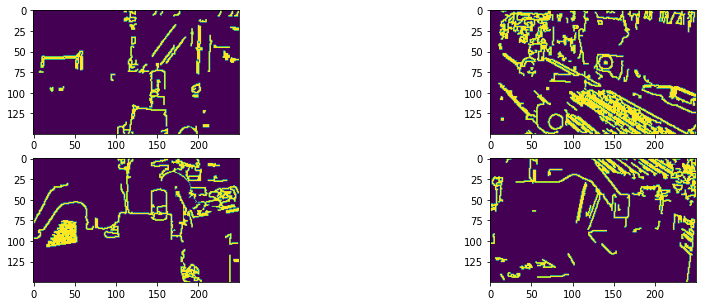

 =====  Illumination Change =====  
 ===== texture change ===== 2101 TL
 Time 2101 TL  Pending not sure if it's aperture effect
 ===== At  2101  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2101  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2101  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2101  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture change ===== 2102 TL
 Time 2102 TL  Pending not sure if it's aperture effect
 ===== At  2102  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2102  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2102  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2102  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture change ===== 2103 TL
 Time 2103 TL  Pending not sure if it's aperture effect
 ===== At  2103 

 ===== At  2124  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2124  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2124  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2124  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture change ===== 2125 TL
 
===== At Frame  2125 Occlusion !! =====   TL 

 ===== At  2125  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2125  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2125  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2125  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture change ===== 2126 TL
 
===== At Frame  2126 Occlusion !! =====   TL 

 ===== At  2126  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2126  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== A

 ===== At  2144  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2144  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2144  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2144  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture change ===== 2145 TL
 
===== At Frame  2145 Occlusion !! =====   TL 

 ===== At  2145  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2145  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2145  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2145  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture change ===== 2146 TL
 
===== At Frame  2146 Occlusion !! =====   TL 

 ===== At  2146  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2146  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== A


	Sub or All Defocus Detected

 ===== At  2169  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2169  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture change ===== 2170 TL
 
===== At Frame  2170 Occlusion !! =====   TL 

 ===== At  2170  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2170  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2170  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2170  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture change ===== 2171 TL
 
===== At Frame  2171 Occlusion !! =====   TL 

 ===== At  2171  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2171  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2171  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2171  Defocus Detected =====  BR

	Sub or


	Sub or All Defocus Detected

 ===== At  2194  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture change ===== 2195 TL
 
===== At Frame  2195 Occlusion !! =====   TL 

 ===== At  2195  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2195  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2195  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2195  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture change ===== 2196 TL
 
===== At Frame  2196 Occlusion !! =====   TL 

 ===== At  2196  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2196  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2196  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2196  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== texture c

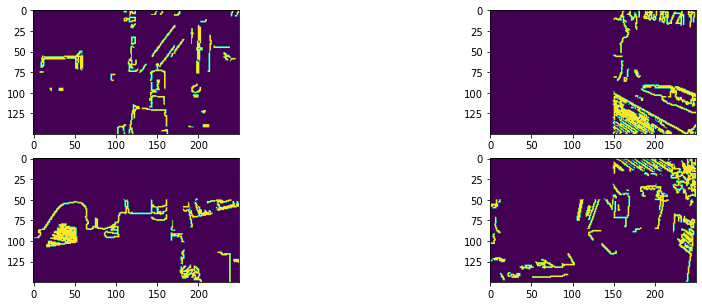

 =====  Illumination Change =====  
 ===== At  2201  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2201  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2201  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2201  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== At  2202  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2202  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2202  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2202  Defocus Detected =====  BR

	Sub or All Defocus Detected

 =====  Illumination Change =====  
 ===== At  2203  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2203  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2203  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2203  Defocus Detected =====  BR

	Sub or All Defocus De

 ===== At  2229  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2229  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2229  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2230  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2230  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2230  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2231  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2231  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2231  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2232  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2232  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2232  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2233  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2233  Defocus 

 ===== At  2258  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2258  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2258  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2258  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2259  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2259  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2259  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2259  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2260  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2260  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2260  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2260  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2261  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2261  Defocus 

 ===== At  2286  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2286  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2286  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2286  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2287  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2287  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2287  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2287  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2288  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2288  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2288  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2288  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2289  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2289  Defocus 

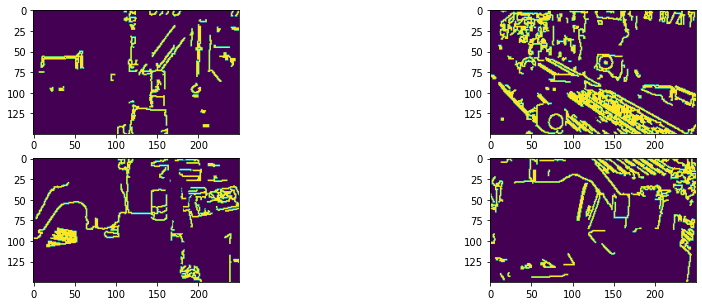

 ===== At  2301  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2301  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2301  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2301  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2302  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2302  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2302  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2302  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2303  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2303  Defocus Detected =====  TR

	Sub or All Defocus Detected

 ===== At  2303  Defocus Detected =====  BL

	Sub or All Defocus Detected

 ===== At  2303  Defocus Detected =====  BR

	Sub or All Defocus Detected

 ===== At  2304  Defocus Detected =====  TL

	Sub or All Defocus Detected

 ===== At  2304  Defocus 

In [ ]:
situation = []

windowTL = subWindow(name = "TL",illuminationThreshold = 10,textureThreshold = 8,apertureLength = 10,defocusThreshold = 0.4,shiftTolerence = 50,shiftRatio = 1,learningRate = 0.0001)
windowTR = subWindow(name = "TR",illuminationThreshold = 10,textureThreshold = 8,apertureLength = 10,defocusThreshold = 0.4,shiftTolerence = 50,shiftRatio = 1,learningRate = 0.0001)
windowBL = subWindow(name = "BL",illuminationThreshold = 10,textureThreshold = 8,apertureLength = 10,defocusThreshold = 0.4,shiftTolerence = 50,shiftRatio = 1,learningRate = 0.0001)
windowBR = subWindow(name = "BR",illuminationThreshold = 10,textureThreshold = 8,apertureLength = 10,defocusThreshold = 0.4,shiftTolerence = 50,shiftRatio = 1,learningRate = 0.0001)

allWindow = [windowTL,windowTR,windowBL,windowBR]

init = 0
kernel = np.ones((2,2),np.float32)/25
frameID = 0
shift_flag = 0


for frame in video:
    #print(frameID)
    frameID = frameID + 1
    #f = cv2.imread(frame)
    f = frame
    grey = cv2.cvtColor(f, cv2.cv2.COLOR_BGR2GRAY)
    edge = cv2.Canny(grey,150,300)
    #edge = grey
    dilateEdge = cv2.dilate(edge,kernel)
    
    windowTL.cache.append(dilateEdge[:int(f.shape[0]/2),:int(f.shape[1]/2)])
    windowTR.cache.append(dilateEdge[:int(f.shape[0]/2),int(f.shape[1]/2):])
    windowBL.cache.append(dilateEdge[int(f.shape[0]/2):,:int(f.shape[1]/2)])
    windowBR.cache.append(dilateEdge[int(f.shape[0]/2):,int(f.shape[1]/2):])
    

    
    
    if frameID < 2000:        
        windowTL.trainingCache.append(dilateEdge[:int(f.shape[0]/2),:int(f.shape[1]/2)])
        windowTR.trainingCache.append(dilateEdge[:int(f.shape[0]/2),int(f.shape[1]/2):])
        windowBL.trainingCache.append(dilateEdge[int(f.shape[0]/2):,:int(f.shape[1]/2)])
        windowBR.trainingCache.append(dilateEdge[int(f.shape[0]/2):,int(f.shape[1]/2):])

    else:
        if init == 0:
            init = 1
            
            for sw in allWindow:
                sw.learningParam()
                sw.illuminationModel = sw.construct_illumination_model(init=0)
                sw.textureModel = sw.construst_GLCM_model(init=0)
        else:
            # Illumination Change detection 
            illumi_flag = False
            tmpflag = False
            for sw in allWindow:
                tmpflag, value = sw.suddenIlluminationChangeDetection()
                illumi_flag= illumi_flag or tmpflag
            if illumi_flag:
                print(" =====  Illumination Change =====  ")
            
            """# Shift Detection 
            tmpflag = False
            shift_flag = False
            
            for sw in allWindow:
                tmpflag, value = sw.shiftDetection(illumi_flag,frameID)
                shift_flag = shift_flag or tmpflag
                shift_value.append(value)
                if shift_flag :
                    print(" == Shift == ",frameID, value )
                    break"""
            """if TL.shiftDetection(tmptl,illumi_flag) or TR.shiftDetection(tmptr,illumi_flag) or LL.shiftDetection(tmpll,illumi_flag) or LR.shiftDetection(tmplr,illumi_flag):
                print("Shifted")
                break
            """
            
            # Texture Change Detection
            texturechangeflag = False
            tmpflag = False
            pending = 0
            occlusion = 0
            for sw in allWindow:
                tmpflag, value = sw.suddenTextureChangeDetection(frameID)
                #print("text V",value,len(value),value[0])
                texturechangeflag = texturechangeflag or tmpflag
                if tmpflag: 
                    if aperture_effect(sw.occlusionDelayQue):
                        occlusion = 1
                        print(" \n===== At Frame ",frameID,"Occlusion !! =====  ",sw.name,"\n")
                    else:
                        pending = 1
                        print(" Time",frameID,sw.name," Pending not sure if it's aperture effect")
                
                else:
                    sw.textureModelUpdate(illumi_flag,frameID)
                    
            
            # Defocus Detection
            tmpflag = False
            defocusflag = False
            for sw in allWindow:
                tmpflag, value = sw.defocusDetection(illumi_flag,frameID)
                defocusflag = defocusflag or tmpflag
                if defocusflag:
                    defocusflag = True
                    print("\n\tSub or All Defocus Detected\n")
            """if TL.defocusDetection(tmptl,illumi_flag,frameID) or TR.defocusDetection(tmptr,illumi_flag,frameID) or LL.defocusDetection(tmpll,illumi_flag,frameID) or LR.defocusDetection(tmplr,illumi_flag,frameID):
                print("\n\nSub or All Defocus Detected\n\n")"""
            
            # outputframe
            situation.append((occlusion,pending,defocusflag,shift_flag))
            
            
        if frameID %100 == 0:
            print(frameID)
            plt.figure(figsize=(15,5))
            plt.subplot(221)
            plt.imshow(windowTL.cache[-1] - windowTL.AGMM.apply(windowTL.cache[-1],learningRate=0))
            plt.subplot(222)
            plt.imshow(windowTR.cache[-1] - windowTR.AGMM.apply(windowTR.cache[-1],learningRate=0))
            plt.subplot(223)
            plt.imshow(windowBL.cache[-1] - windowBL.AGMM.apply(windowBL.cache[-1],learningRate=0))
            plt.subplot(224)
            plt.imshow(windowBR.cache[-1] - windowBR.AGMM.apply(windowBR.cache[-1],learningRate=0))
            
            plt.show()
    
    